# Transfer Learning with TensorFlow Part 2: Fine-tuning

In [1]:
## Download the data


# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-28 21:26:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 142.251.172.207, 108.177.112.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   207MB/s    in 0.8s    

2023-12-28 21:27:00 (207 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:

import tensorflow as tf


IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"



print("Training images:")
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMAGE_SHAPE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMAGE_SHAPE,
                                                                           label_mode="categorical")

Training images:
Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [3]:
# Check the training data datatype
train_data_10_percent


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [4]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Modeling Experiments:

* Model 1: a transfer learning model using the Keras Functional API

* Model 2: a feature extraction transfer learning model on 1% of the data with data augmentation

* Model 3: a feature extraction transfer learning model on 10% of the data with data augmentation

* Model 4: a fine-tuned transfer learning model on 10% of the data

* Model 5: a fine-tuned transfer learning model on 100% of the data

* Model 6: the same as model_3 but training for 10 epochs instead of 5

* Model 7: model 6 plus fine-tuning the last 20 layers on 10% for another 10 epochs



#  Model 1: Building a transfer learning model using the Keras Functional API

In [6]:


# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned weights are not updated)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2 (EfficientNetV2B0 has a rescaling step in the begining of the model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model
history_10_percent_model_1 = model_1.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=len(test_data_10_percent), # to use less data during the validation step to speed up the tests, replace --> validation_steps=int(0.025*len(test_data_10_percent))
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20231228-212729
Epoch 1/5
24/24 [==============================] - 31s 587ms/step - loss: 1.9097 - accuracy: 0.3693 - val_loss: 1.3464 - val_accuracy: 0.7128
Epoch 2/5
24/24 [==============================] - 12s 495ms/step - loss: 1.1537 - accuracy: 0.7600 - val_loss: 0.9082 - val_accuracy: 0.8084
Epoch 3/5
24/24 [==============================] - 11s 415ms/step - loss: 0.8501 - accuracy: 0.8280 - val_loss: 0.7204 - val_accuracy: 0.8340
Epoch 4/5
24/24 [==============================] - 7s 280ms/step - loss: 0.6987 - accuracy: 0.8427 - val_loss: 0.6306 - val_accuracy: 0.8484
Epoch 5/5
24/24 [==============================] - 12s 503ms/step - loss: 0.5961 - accuracy: 0.8693 - val_loss: 0.5652 - val_accuracy: 0.8544


In [7]:

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [8]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

In [9]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


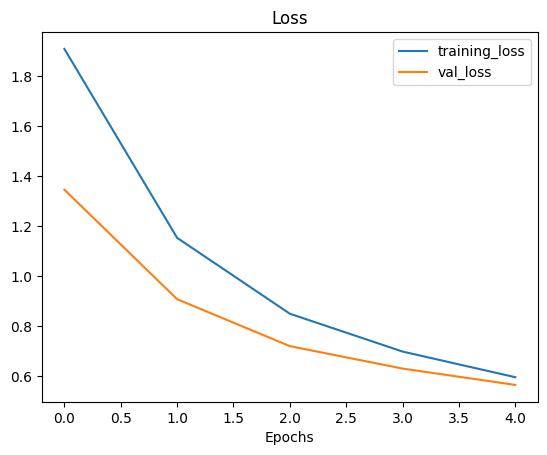

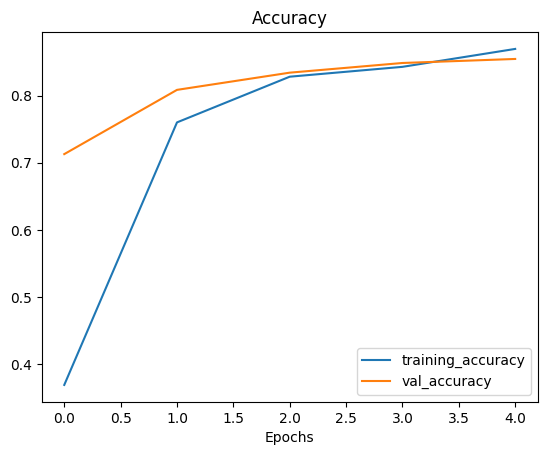

In [10]:
plot_loss_curves(history_10_percent_model_1)

In [12]:
results_10_percent_data_aug_model_1 = model_1.evaluate(test_data_10_percent)
results_10_percent_data_aug_model_1

79/79 [==============================] - 7s 70ms/step - loss: 0.5652 - accuracy: 0.8544


[0.5652041435241699, 0.8543999791145325]

In [13]:

# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [14]:

# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [15]:

# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()



# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"


--2023-12-28 21:30:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   196MB/s    in 0.6s    

2023-12-28 21:30:36 (196 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

# data augmentation can be part of the model, and it will only be on during training. On inference it will be skiped.
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")


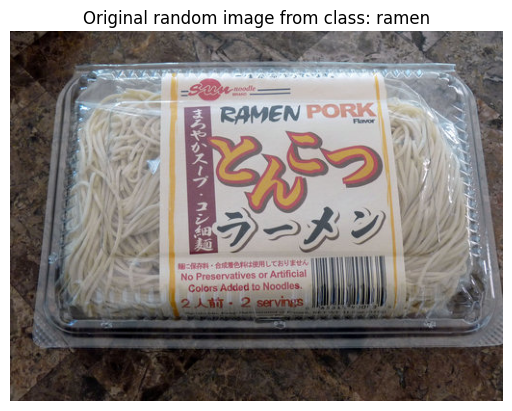

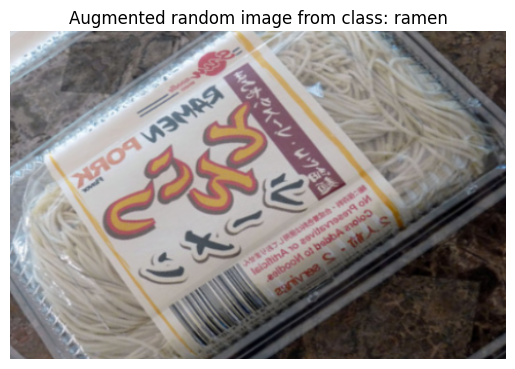

In [18]:

# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

# Model 2: Feature extraction transfer learning on 1% of the data with data augmentation

In [19]:

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent_model_2 = model_2.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231228-213101
Epoch 1/5
3/3 [==============================] - 18s 5s/step - loss: 2.3566 - accuracy: 0.1286 - val_loss: 2.1888 - val_accuracy: 0.1868
Epoch 2/5
3/3 [==============================] - 14s 6s/step - loss: 2.1267 - accuracy: 0.2429 - val_loss: 2.0862 - val_accuracy: 0.3012
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 1.9814 - accuracy: 0.4000 - val_loss: 2.0042 - val_accuracy: 0.3644
Epoch 4/5
3/3 [==============================] - 9s 4s/step - loss: 1.7941 - accuracy: 0.5429 - val_loss: 1.9296 - val_accuracy: 0.3972
Epoch 5/5
3/3 [==============================] - 13s 6s/step - loss: 1.7054 - accuracy: 0.5714 - val_loss: 1.8565 - val_accuracy: 0.4276


In [20]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [21]:
results_1_percent_data_aug = model_2.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 67ms/step - loss: 1.8565 - accuracy: 0.4276


[1.8565248250961304, 0.4275999963283539]

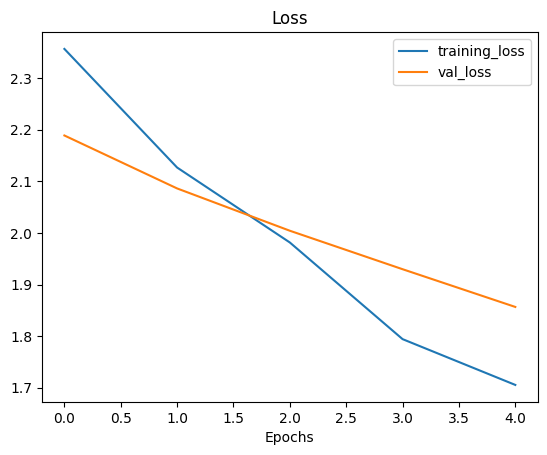

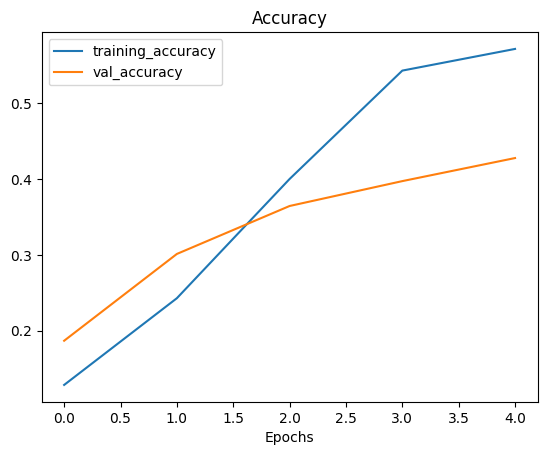

In [22]:
plot_loss_curves(history_1_percent_model_2)

# Model 3: Feature extraction transfer learning with 10% of data and data augmentation

In [23]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [24]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, this could be skipped, here for practice
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [25]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet since it has it build it in
], name ="data_augmentation")


# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base/backbone model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


In [26]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model


model_3 = create_base_model()


In [27]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)


In [28]:
initial_epochs = 5
history_10_percent_data_aug_model_3 = model_3.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231228-213247
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0700 - accuracy: 0.2907
Epoch 1: val_loss improved from inf to 1.51408, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 43s 1s/step - loss: 2.0700 - accuracy: 0.2907 - val_loss: 1.5141 - val_accuracy: 0.6544
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4057 - accuracy: 0.6600
Epoch 2: val_loss improved from 1.51408 to 1.05701, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 1s/step - loss: 1.4057 - accuracy: 0.6600 - val_loss: 1.0570 - val_accuracy: 0.7668
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1076 - accuracy: 0.7453
Epoch 3: val_loss improved from 1.05701 to 0.84446, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=======

In [29]:
results_10_percent_data_aug_model_3 = model_3.evaluate(test_data)
results_10_percent_data_aug_model_3

79/79 [==============================] - 8s 93ms/step - loss: 0.6507 - accuracy: 0.8308


[0.650688111782074, 0.8307999968528748]

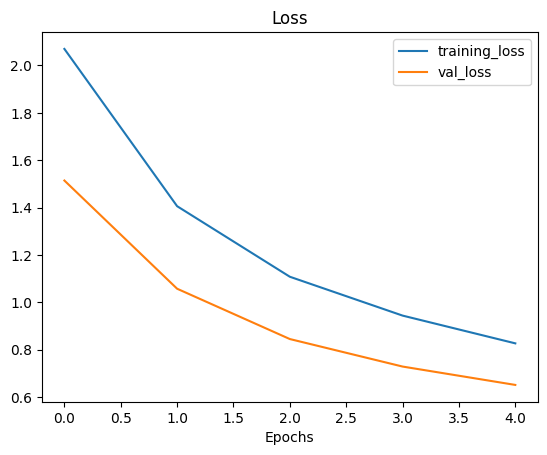

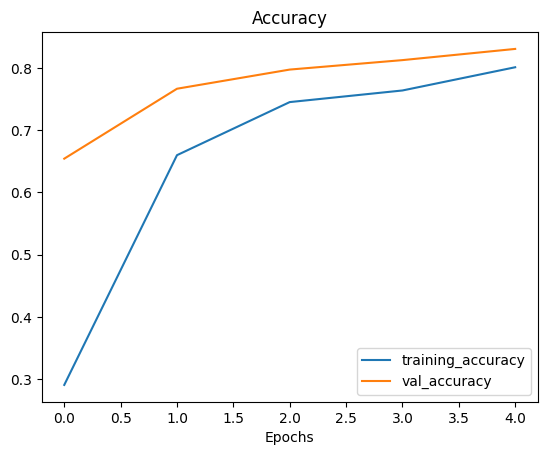

In [30]:
plot_loss_curves(history_10_percent_data_aug_model_3)

# Check saved model weights

In [31]:

# Load in saved model weights and evaluate model
model_3.load_weights(checkpoint_path)
loaded_weights_model_results = model_3.evaluate(test_data)

79/79 [==============================] - 5s 60ms/step - loss: 0.6507 - accuracy: 0.8308


In [32]:
# native model and the loaded weights should be the same
results_10_percent_data_aug_model_3 == loaded_weights_model_results

True

In [33]:
print(results_10_percent_data_aug_model_3, loaded_weights_model_results)

[0.650688111782074, 0.8307999968528748] [0.650688111782074, 0.8307999968528748]


In [34]:
# Probably because how number are saved this returs negative.
# using np.is close should result in True

import numpy as np
np.isclose(np.array(results_10_percent_data_aug_model_3), np.array(loaded_weights_model_results))

array([ True,  True])

In [35]:
model_3.layers

In [36]:
for layer_number, layer in enumerate(model_3.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7e07fdd46020> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7e0801fe2e00> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7e07fdd6fa90> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e07fde83e50> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7e07fdd8c5e0> | Trainable? True


In [37]:

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [38]:
results_10_percent_data_aug_model_3 = model_3.evaluate(test_data)
results_10_percent_data_aug_model_3

79/79 [==============================] - 5s 64ms/step - loss: 0.6507 - accuracy: 0.8308


[0.6506878137588501, 0.8307999968528748]

# Model 4: Fine-tunning and existing model on 10% of the data

In [39]:
model_3.layers

In [40]:
model_3_base_model = model_3.layers[2]
model_3_base_model.name


'efficientnetv2-b0'

In [41]:
# How many layers are trainable in our model_3_base_model?
print(len(model_3_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)


0


In [42]:
# Make all the layers in model_3_base_model trainable
model_3_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_3_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate is 10x lower than before for fine-tuning. This is to try to avoid overfitting (more infor on https://arxiv.org/abs/1801.06146).
                metrics=["accuracy"])

In [43]:

print(len(model_3.trainable_variables))

12


In [44]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug_model_4 = model_3.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug_model_3.epoch[-1], # start from previous last epoch
                                               validation_steps=len(test_data),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231228-213558
Epoch 5/10
24/24 [==============================] - 36s 1s/step - loss: 0.7232 - accuracy: 0.8000 - val_loss: 0.5278 - val_accuracy: 0.8280
Epoch 6/10
24/24 [==============================] - 24s 957ms/step - loss: 0.5833 - accuracy: 0.8240 - val_loss: 0.4801 - val_accuracy: 0.8400
Epoch 7/10
24/24 [==============================] - 23s 976ms/step - loss: 0.5548 - accuracy: 0.8200 - val_loss: 0.4619 - val_accuracy: 0.8432
Epoch 8/10
24/24 [==============================] - 21s 870ms/step - loss: 0.5062 - accuracy: 0.8373 - val_loss: 0.4512 - val_accuracy: 0.8504
Epoch 9/10
24/24 [==============================] - 22s 916ms/step - loss: 0.4860 - accuracy: 0.8520 - val_loss: 0.4347 - val_accuracy: 0.8524
Epoch 10/10
24/24 [==============================] - 25s 1s/step - loss: 0.4045 - accuracy: 0.8827 - val_loss: 0.4438 - val_accuracy: 0.8536


In [45]:
results_fine_10_percent_data_aug_model_4 = model_3.evaluate(test_data)
results_fine_10_percent_data_aug_model_4

79/79 [==============================] - 6s 77ms/step - loss: 0.4438 - accuracy: 0.8536


[0.4438050389289856, 0.853600025177002]

In [46]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.2906666696071625, 0.6600000262260437, 0.7453333139419556, 0.7639999985694885, 0.8013333082199097, 0.800000011920929, 0.8240000009536743, 0.8199999928474426, 0.8373333215713501, 0.8519999980926514, 0.8826666474342346]


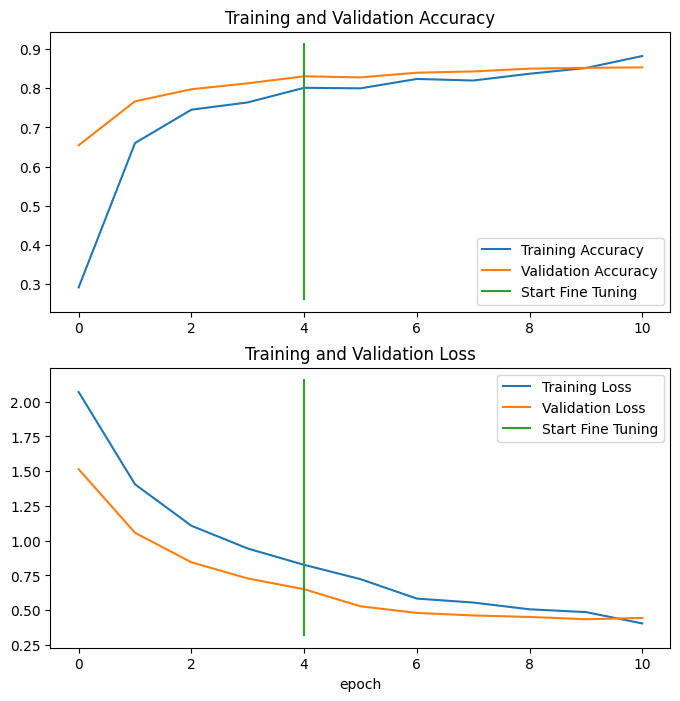

In [47]:
compare_historys(original_history=history_10_percent_data_aug_model_3,
                 new_history=history_fine_10_percent_data_aug_model_4,
                 initial_epochs=5)


# Model 5: Fine-tuning an existing model all of the data

In [48]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()



# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-12-28 21:39:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.207, 142.250.1.207, 108.177.121.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  95.2MB/s    in 6.8s    

2023-12-28 21:39:35 (72.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [49]:

import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [52]:
# Load weights from Checkpoint (the same stage as before the finetuning on model 4)
model_3 = create_base_model(learning_rate=0.0001)
model_3.load_weights(checkpoint_path)

In [53]:
model_3.evaluate(test_data)

79/79 [==============================] - 9s 77ms/step - loss: 0.6507 - accuracy: 0.8308


[0.6506880521774292, 0.8307999968528748]

In [54]:
results_fine_10_percent_data_aug_model_4

[0.4438050389289856, 0.853600025177002]

In [55]:
# last two cells are different confirmning that we have reverted to the model prior to finetunning

In [56]:
for layer_number, layer in enumerate(model_3.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [57]:

# Unfreeze the top 10 layers in model_3's base_model
model_3_base_model = model_3.layers[2]
model_3_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_3_base_model.layers[:-10]:
  layer.trainable = False


In [58]:
print(len(model_3.trainable_variables))

12


In [59]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [60]:

fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_3.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug_model_3.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20231228-214319
Epoch 5/10
235/235 [==============================] - 138s 546ms/step - loss: 0.7145 - accuracy: 0.7715 - val_loss: 0.3706 - val_accuracy: 0.8780
Epoch 6/10
235/235 [==============================] - 116s 492ms/step - loss: 0.5947 - accuracy: 0.8079 - val_loss: 0.3459 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 90s 382ms/step - loss: 0.5462 - accuracy: 0.8223 - val_loss: 0.3183 - val_accuracy: 0.8932
Epoch 8/10
235/235 [==============================] - 79s 333ms/step - loss: 0.4995 - accuracy: 0.8408 - val_loss: 0.2869 - val_accuracy: 0.9028
Epoch 9/10
235/235 [==============================] - 79s 337ms/step - loss: 0.4768 - accuracy: 0.8496 - val_loss: 0.2825 - val_accuracy: 0.9068
Epoch 10/10
235/235 [==============================] - 82s 347ms/step - loss: 0.4505 - accuracy: 0.8564 - val_loss: 0.2774 - val_accuracy: 0.9064


In [61]:

results_fine_tune_full_data_model_5 = model_3.evaluate(test_data)
results_fine_tune_full_data_model_5

79/79 [==============================] - 5s 58ms/step - loss: 0.2774 - accuracy: 0.9064


[0.27743273973464966, 0.9064000248908997]

5
11
[0.2906666696071625, 0.6600000262260437, 0.7453333139419556, 0.7639999985694885, 0.8013333082199097, 0.7714666724205017, 0.8078666925430298, 0.8222666382789612, 0.8407999873161316, 0.8496000170707703, 0.8564000129699707]


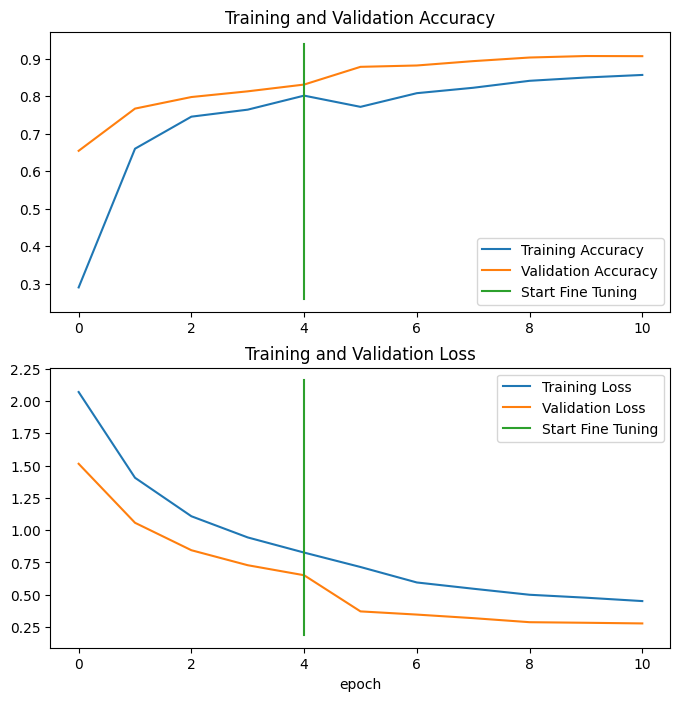

In [65]:
compare_historys(original_history=history_10_percent_data_aug_model_3,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

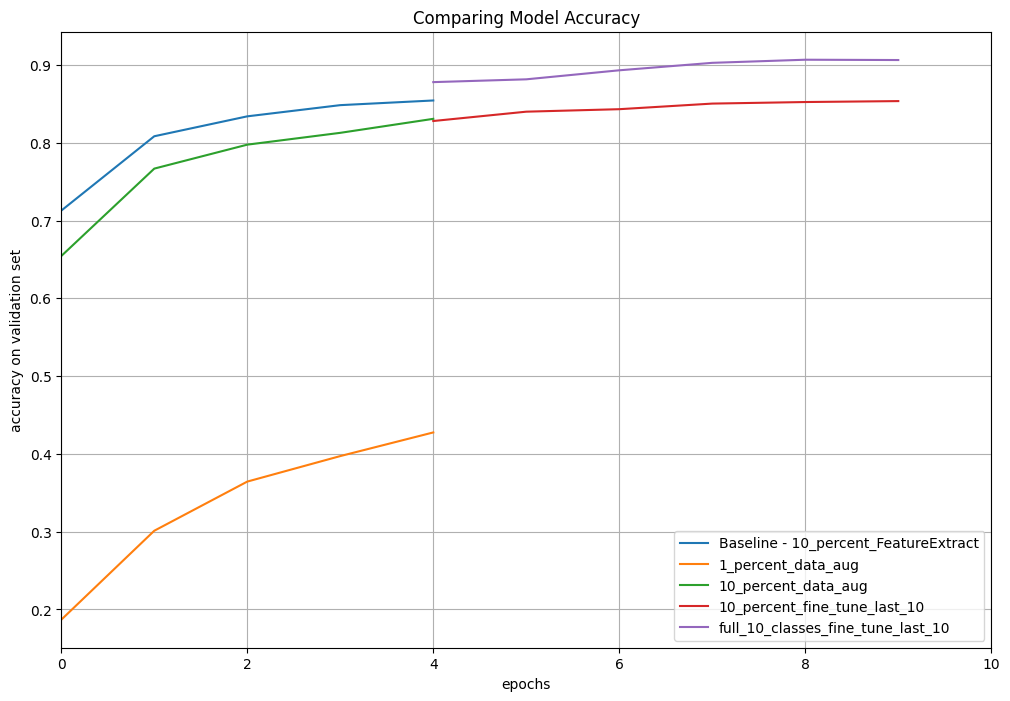

In [72]:
# Comparing Models accuracy

fig = plt.figure(figsize=(12,8))
plt.plot(range(initial_epochs),history_10_percent_model_1.history['val_accuracy'],label='Baseline - 10_percent_FeatureExtract')
plt.plot(range(initial_epochs),history_1_percent_model_2.history['val_accuracy'],label='1_percent_data_aug')
plt.plot(range(initial_epochs),history_10_percent_data_aug_model_3.history['val_accuracy'],label='10_percent_data_aug')
plt.plot([4,5,6,7,8,9],history_fine_10_percent_data_aug_model_4.history['val_accuracy'],label='10_percent_fine_tune_last_10')
plt.plot([4,5,6,7,8,9],history_fine_10_classes_full.history['val_accuracy'],label='full_10_classes_fine_tune_last_10')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,fine_tune_epochs])
plt.ylabel('accuracy on validation set')
plt.grid(True)
plt.title("Comparing Model Accuracy")
plt.show()
fig.savefig('compare-accuracy.jpg')
plt.close(fig)

In [73]:
# Model 6: the same as model 3 but training for 10 epochs instead of 5

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base/backbone model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_6 = tf.keras.Model(inputs, outputs)

# Compile
model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])



# Setup checkpoint path
checkpoint_path_v2 = "ten_percent_model_checkpoints_weights_v2/checkpoint.ckpt" # note: saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_v2,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)


initial_epochs = 10
history_10_percent_data_aug_model_6 = model_6.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug_10epochs"),
                                                     checkpoint_callback])






Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_10epochs/20231228-220449
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0249 - accuracy: 0.3427
Epoch 1: val_loss improved from inf to 1.49725, saving model to ten_percent_model_checkpoints_weights_v2/checkpoint.ckpt
24/24 [==============================] - 25s 655ms/step - loss: 2.0249 - accuracy: 0.3427 - val_loss: 1.4972 - val_accuracy: 0.6676
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.4257 - accuracy: 0.6240
Epoch 2: val_loss improved from 1.49725 to 1.06654, saving model to ten_percent_model_checkpoints_weights_v2/checkpoint.ckpt
24/24 [==============================] - 16s 667ms/step - loss: 1.4257 - accuracy: 0.6240 - val_loss: 1.0665 - val_accuracy: 0.7636
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.1045 - accuracy: 0.7440
Epoch 3: val_loss improved from 1.06654 to 0.83966, saving model to ten_percent_model_checkpoints_weights_v2/che

In [74]:
results_10_percent_data_aug_model_6 = model_6.evaluate(test_data)
results_10_percent_data_aug_model_6

79/79 [==============================] - 6s 63ms/step - loss: 0.4884 - accuracy: 0.8564


[0.4883558452129364, 0.8564000129699707]

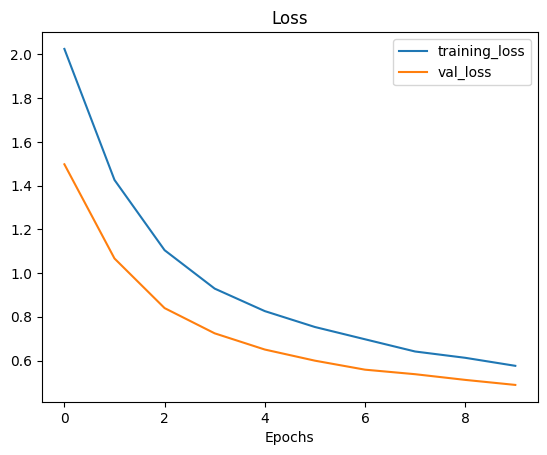

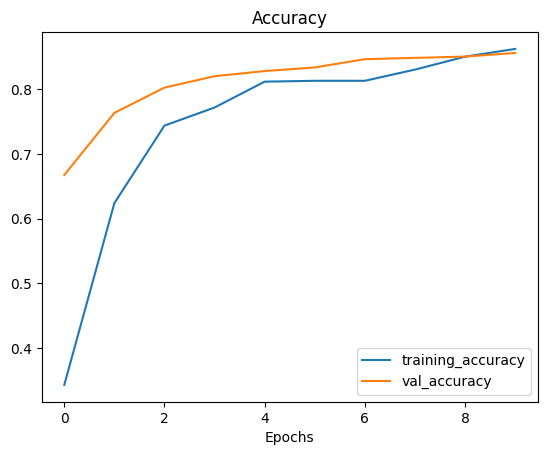

In [76]:
plot_loss_curves(history_10_percent_data_aug_model_6)

In [92]:
# Model 7: model 6 plus fine-tuning the last 20 layers on 10% for another 10 epochs
# Load in saved model weights and evaluate model
model_7 = create_base_model(learning_rate=0.0001)
model_7.load_weights(checkpoint_path_v2)
loaded_weights_model_results = model_7.evaluate(test_data)


79/79 [==============================] - 9s 64ms/step - loss: 0.4884 - accuracy: 0.8564


In [93]:

model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [94]:
# How many layers are trainable in our model_6_base_model?
print(len(model_7.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)


2


In [96]:

# Unfreeze the top 20 layers in model_7's base_model


model_7_base_model = model_7.layers[2]
model_7_base_model.trainable = True


# Freeze all layers except for the last 20
for layer in model_7_base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [97]:
print(len(model_7.trainable_variables))

18


In [103]:

# Check which layers are tuneable in the base model
test_1 = model_7.layers[2]
for layer_number, layer in enumerate(test_1.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [104]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug_model_7 = model_7.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug_model_6.epoch[-1], # start from previous last epoch
                                               validation_steps=len(test_data),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_20")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_20/20231228-223404
Epoch 10/20
24/24 [==============================] - 38s 552ms/step - loss: 0.4854 - accuracy: 0.8613 - val_loss: 0.4244 - val_accuracy: 0.8584
Epoch 11/20
24/24 [==============================] - 9s 384ms/step - loss: 0.4270 - accuracy: 0.8587 - val_loss: 0.4252 - val_accuracy: 0.8584
Epoch 12/20
24/24 [==============================] - 11s 429ms/step - loss: 0.3715 - accuracy: 0.8853 - val_loss: 0.4247 - val_accuracy: 0.8572
Epoch 13/20
24/24 [==============================] - 11s 456ms/step - loss: 0.3530 - accuracy: 0.8907 - val_loss: 0.4159 - val_accuracy: 0.8584
Epoch 14/20
24/24 [==============================] - 10s 418ms/step - loss: 0.3248 - accuracy: 0.9107 - val_loss: 0.4300 - val_accuracy: 0.8620
Epoch 15/20
24/24 [==============================] - 17s 727ms/step - loss: 0.2946 - accuracy: 0.9053 - val_loss: 0.4312 - val_accuracy: 0.8628
Epoch 16/20
24/24 [======================

In [105]:
results_10_percent_data_aug_model_7 = model_7.evaluate(test_data)
results_10_percent_data_aug_model_7

79/79 [==============================] - 6s 76ms/step - loss: 0.4324 - accuracy: 0.8708


[0.4323734939098358, 0.8708000183105469]

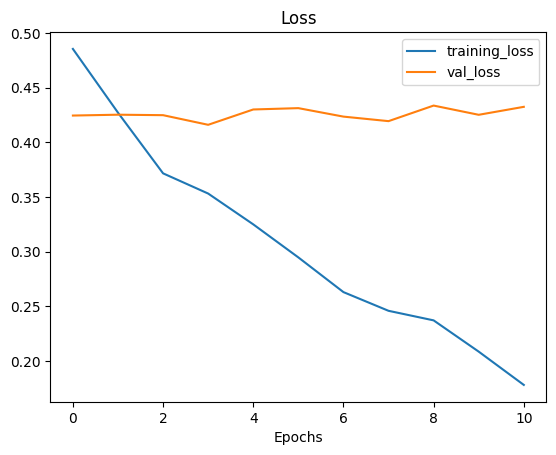

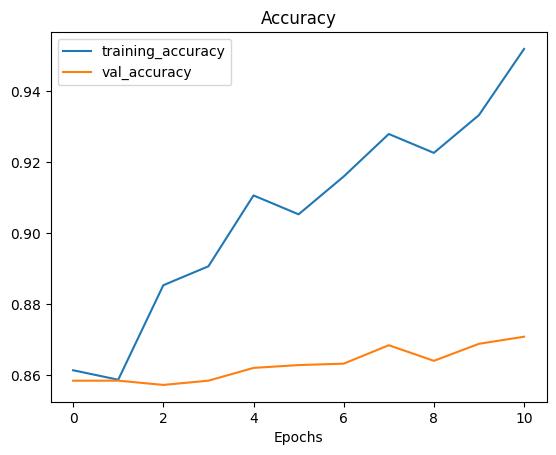

In [106]:
plot_loss_curves(history_fine_10_percent_data_aug_model_7)

10
21
[0.3426666557788849, 0.6240000128746033, 0.7440000176429749, 0.7720000147819519, 0.8119999766349792, 0.8133333325386047, 0.8133333325386047, 0.8306666612625122, 0.8506666421890259, 0.862666666507721, 0.8613333106040955, 0.8586666584014893, 0.8853333592414856, 0.890666663646698, 0.9106666445732117, 0.9053333401679993, 0.9160000085830688, 0.9279999732971191, 0.9226666688919067, 0.9333333373069763, 0.9520000219345093]


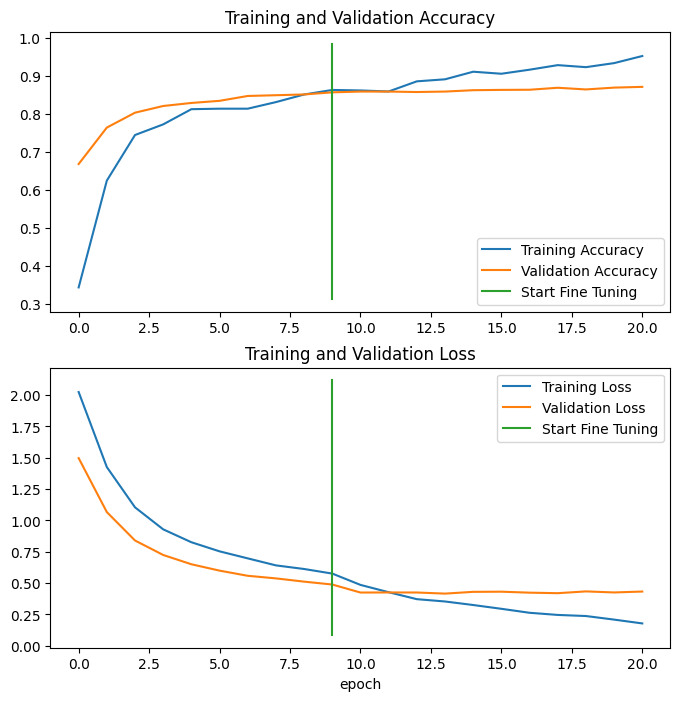

In [108]:
compare_historys(original_history=history_10_percent_data_aug_model_6,
                 new_history=history_fine_10_percent_data_aug_model_7,
                 initial_epochs=10)

# overfitting. Metrics on the training set are better than on the validation set.

# Accuracy on the training set was 95.2% vs 87.4% on the validation set.

# Best model was model_5: full_10_classes_fine_tune_last_10